## Vision Model (can only use Image to search for similar Image)

## Observe Images

In [ ]:
from helpers.models import ResNet50Embedder, ViT_B16_Embedder
resnet_model = ResNet50Embedder()

Torchvision loaded
Torch loaded
Transforms loaded


d:\Bachelor\Curriculum\HK251\DBMS\elastic-search\env_win\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Timm loaded
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1),

## Store raw embedding

In [2]:
# init es client and helpter
from helpers.es import ESHelper
from elasticsearch import Elasticsearch

import os
from dotenv import load_dotenv
import sys

sys.path.append("D:\\Bachelor\\Curriculum\\HK251\\DBMS\\elastic-search")

load_dotenv()

ES_PASSWORD = os.getenv("ES_PASSWORD")

es = Elasticsearch(
    ["https://localhost:9200"],     # list of nodes in cluster
    ca_certs="http_ca.crt",  
    basic_auth=("elastic", ES_PASSWORD)  # if authentication enabled
)
es_helper = ESHelper(es, index="images", delete_old_idx=False)
es_helper_base64 = ESHelper(es, index="images_base64", delete_old_idx=True)

In [3]:
# check if es client is connected successfully
es_helper.ping()
es_helper_base64.ping()

True

In [4]:
from pprint import pprint

# # check content of index "images"
# es_helper.get_index_info()

In [ ]:
es_helper_base64.from_folder_to_es(
    folder_path="images",
    mode="raw"
)

In [6]:
es_helper_base64.get_index_info()

First document:
{'AcquisitionTime': '113226.822500',
 'BitsStored': 12,
 'BodyPartExamined': 'LSPINE',
 'Columns': 384,
 'FrameOfReferenceUID': '1.3.6.1.4.1.9590.100.1.2.276149006711474780633220748003688454356',
 'ImageOrientationPatient': [-3.58e-13,
                             1.0,
                             -2.05103e-10,
                             -0.0017453003597,
                             -2.05103e-10,
                             -0.9999984769622],
 'ImagePositionPatient': [-9.4182718116536, -117.2289199542, 129.92119657426],
 'InstanceNumber': 3,
 'Modality': 'MR',
 'PatientAge': '030Y',
 'PatientSize': 1.8,
 'PatientWeight': 80.0,
 'PixelRepresentation': 0,
 'Rows': 384,
 'SOPInstanceUID': '1.3.6.1.4.1.9590.100.1.2.391129174411098040707274026470301292959',
 'SeriesInstanceUID': '1.3.12.2.1107.5.2.40.50233.2016062111353913081808190.0.0.0',
 'SliceThickness': 4.0,
 'SpacingBetweenSlices': 4.8,
 'StudyInstanceUID': '1.3.12.2.1107.5.2.40.50233.30000016062107154769200000007'

### Case study 1: Get all images of a Series

1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0


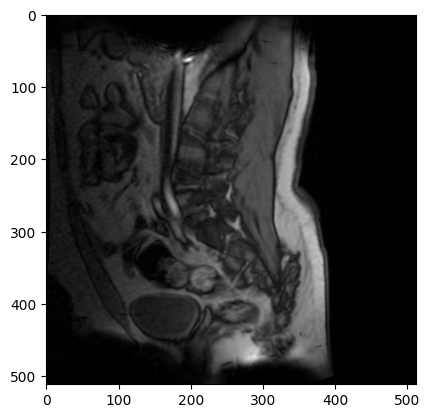

In [31]:
from helpers.ima_loader import load_dicom, dicom_to_array, get_metadata
from io import BytesIO
from base64 import b64decode
import numpy as np

dicom = load_dicom("images/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_001.ima")
metadata = get_metadata(dicom)
print(metadata['SeriesInstanceUID'])
image = dicom_to_array(load_dicom("images/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_001.ima"))
image = Image.fromarray(image.astype(np.uint8))
plt.imshow(image, cmap='gray')

Top 5 images:


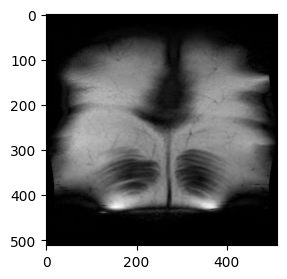

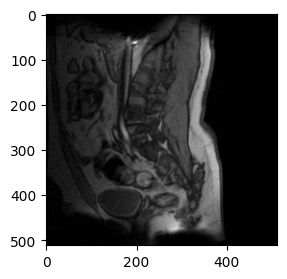

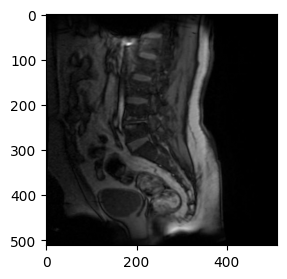

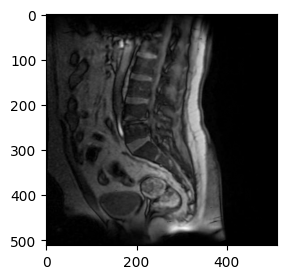

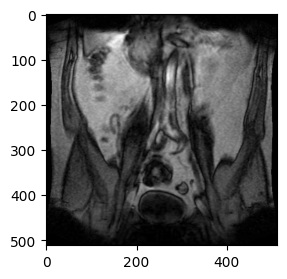

In [30]:
from matplotlib import pyplot as plt
import base64
from io import BytesIO
from PIL import Image
import numpy as np

res = es_helper_base64.es_client.search(
    index="images_base64",
    body={
        "query": {
            "term": {
                "SeriesInstanceUID.keyword": "1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0"
            }
        },
        "size": 5
    },
)

print("Top 5 images:")
for hit in res['hits']['hits']:
    plt.figure(figsize=(3, 3))
    base64_str = hit['_source']['image']
    img_bytes = base64.b64decode(base64_str)
    image = Image.open(BytesIO(img_bytes))
    plt.imshow(image, cmap='gray')


## Store embedding and image link

In [5]:
# init az helper
from helpers.azure_helper import AzureHelper

azure_helper = AzureHelper(
    connection_string=os.getenv("AZURE_STORAGE_CONNECTION_STRING"),
    container_name=os.getenv("AZURE_BLOB_STORAGE_CONTAINER_NAME")
)

# es_helper.from_folder_to_es("images/", mode='embed', model=resnet_model, azure_helper=azure_helper)  # use 'embed', 'link', or 'raw' mode

In [6]:
# get index info after indexing
es_helper.get_index_info()

# check fields types
mapping = es_helper.get_index_mapping()
pprint(mapping)

First document:
{'AcquisitionTime': '145054.200000',
 'BitsStored': 12,
 'BodyPartExamined': 'LSPINE',
 'Columns': 320,
 'FrameOfReferenceUID': '1.3.6.1.4.1.9590.100.1.2.110589646012243035409658819880819438470',
 'ImageOrientationPatient': [1.0,
                             0.0,
                             0.0,
                             0.0,
                             -0.1062640706505,
                             -0.9943379442065],
 'ImagePositionPatient': [-139.32453769445, 42.094907360548, 105.84974559383],
 'InstanceNumber': 13,
 'Modality': 'MR',
 'PatientAge': '051Y',
 'PatientSize': 1.8,
 'PatientWeight': 80.0,
 'PixelRepresentation': 0,
 'Rows': 320,
 'SOPInstanceUID': '1.3.6.1.4.1.9590.100.1.2.367775904312710825233560672040678394357',
 'SeriesInstanceUID': '1.3.12.2.1107.5.2.40.50233.2016042414541161953230098.0.0.0',
 'SliceThickness': 4.0,
 'SpacingBetweenSlices': 4.8,
 'StudyInstanceUID': '1.3.12.2.1107.5.2.40.50233.30000016042407054180000000034',
 'image': [0.00157828

In [7]:
# # update azure image link to each document in index "images"
# from helpers.azure_helper import AzureHelper
# azure_helper = AzureHelper(
#     connection_string=os.getenv("AZURE_STORAGE_CONNECTION_STRING"),
#     container_name=os.getenv("AZURE_BLOB_STORAGE_CONTAINER_NAME")
# )

# for root, dirs, files in os.walk("images/"):
#     for idx, file in enumerate(files):
#         if file.lower().endswith(('.ima')):
#             local_path = os.path.join(root, file)
#             blob_path = os.path.relpath(local_path, "images/").replace("\\", "/").replace(".ima", ".png")
#             azure_url = azure_helper.get_azure_blob_url(blob_path=blob_path)
#             es_helper.update_img_link_in_es(dicom_path=local_path, new_link=azure_url)
#         if idx % 100 == 0:
#             print(f"Added img link {azure_url} to document {file}. Processed {idx} files.")

## Retrieve information via Text field

### Case study 2: Retrieve all images in a series

Total number of images in this series: 15
Images links in this series:
 - https://esimagedatastorage.blob.core.windows.net/mri-images/0007/L-SPINE_CLINICAL_LIBRARIES_20160424_144139_347000/T1_TSE_COR_320_0004/T1_TSE_COR__0007_013.png
 - https://esimagedatastorage.blob.core.windows.net/mri-images/0007/L-SPINE_CLINICAL_LIBRARIES_20160424_144139_347000/T1_TSE_COR_320_0004/T1_TSE_COR__0007_014.png
 - https://esimagedatastorage.blob.core.windows.net/mri-images/0007/L-SPINE_CLINICAL_LIBRARIES_20160424_144139_347000/T1_TSE_COR_320_0004/T1_TSE_COR__0007_015.png
 - https://esimagedatastorage.blob.core.windows.net/mri-images/0007/L-SPINE_CLINICAL_LIBRARIES_20160424_144139_347000/T1_TSE_COR_320_0004/T1_TSE_COR__0007_001.png
 - https://esimagedatastorage.blob.core.windows.net/mri-images/0007/L-SPINE_CLINICAL_LIBRARIES_20160424_144139_347000/T1_TSE_COR_320_0004/T1_TSE_COR__0007_002.png
 - https://esimagedatastorage.blob.core.windows.net/mri-images/0007/L-SPINE_CLINICAL_LIBRARIES_20160424_144139_347

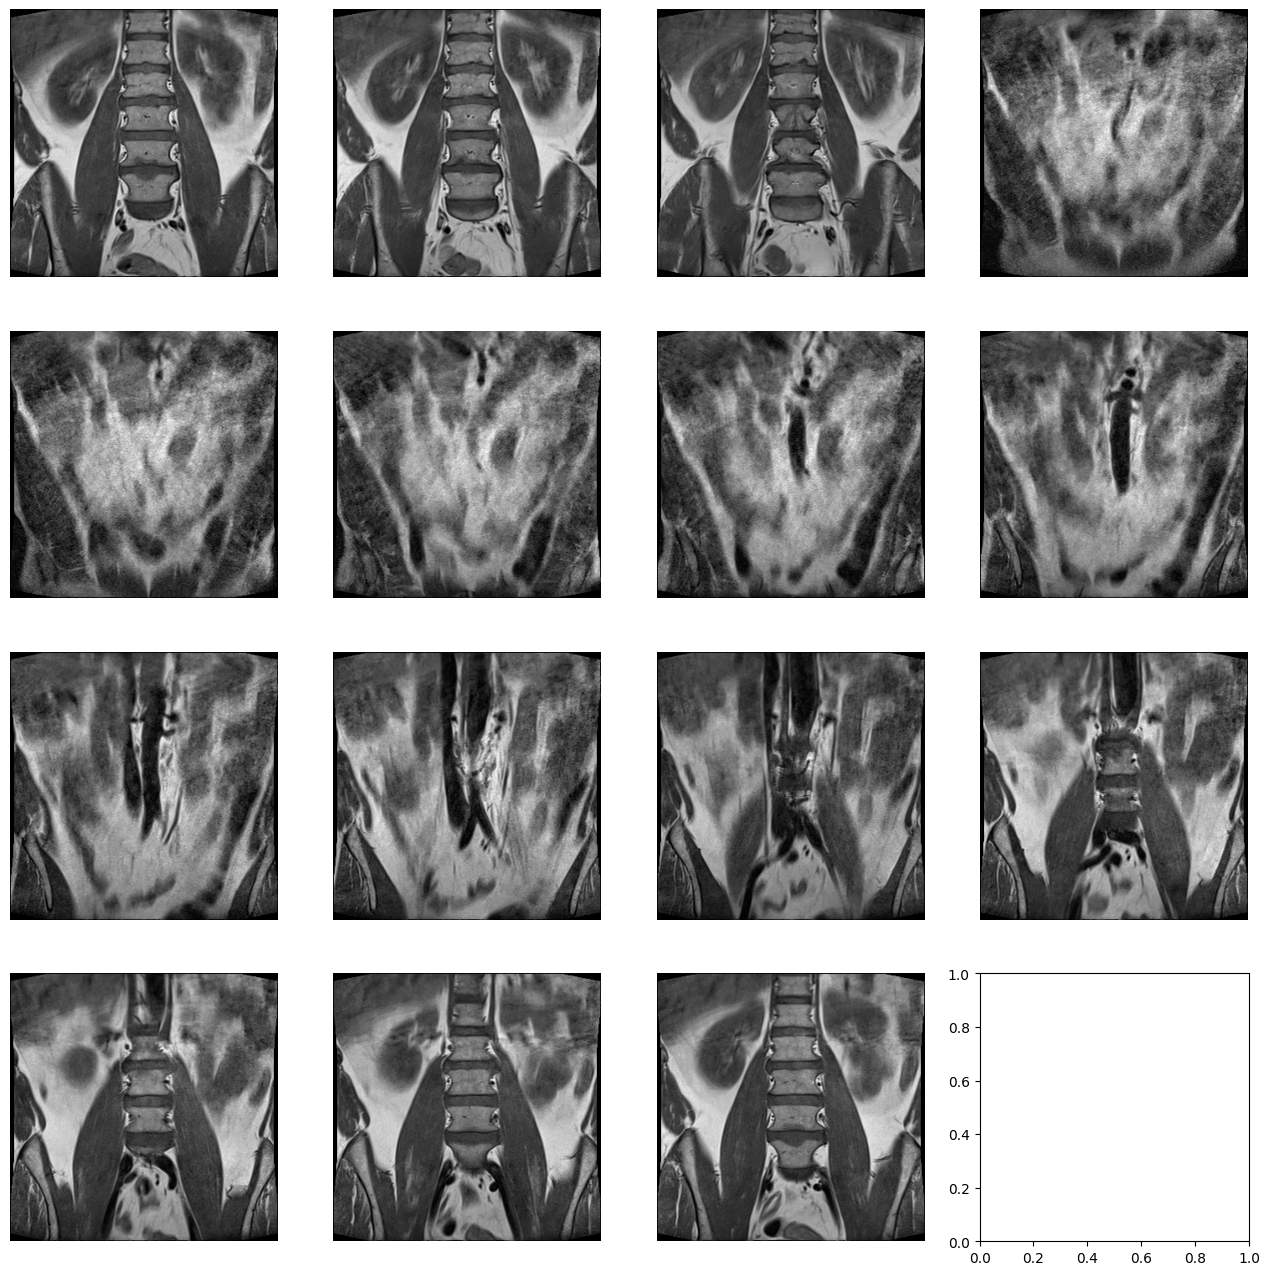

In [8]:
response = es_helper.es_client.search(
    index="images",
    body={
        "_source": ["SOPInstanceUID", "image_link", "SeriesInstanceUID"],
        "query": {
            "term": {
                "SeriesInstanceUID.keyword": '1.3.12.2.1107.5.2.40.50233.2016042414541161953230098.0.0.0'
            }
        },
        "size": 1000    # max size of returned results
    }
)

print(f"Total number of images in this series: {response['hits']['total']['value']}")
print(f"Images links in this series:")
for hit in response['hits']['hits']:
    print(f" - {hit['_source']['image_link']}")
    
print(f"Actual images in this series (get from storage):")
azure_helper.show_images_from_response(response)

## Retrieve information via images

### Case study 3: Retrieve ROP instance ID via image

ROPInstanceUID: (0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.408350004413629474808950603914144527198
Patient's age: (0010,1010) Patient's Age                       AS: '045Y'
SeriesInstanceUID: (0020,000E) Series Instance UID                 UI: 1.3.12.2.1107.5.2.40.50233.2016050312244775818809563.0.0.0


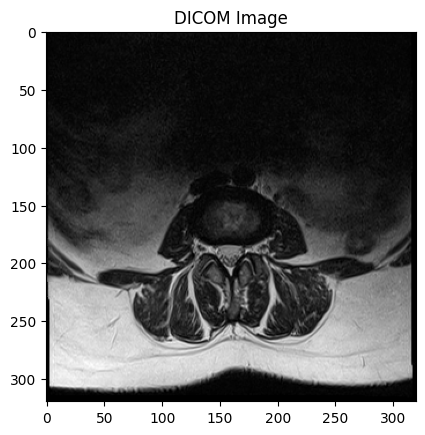

In [42]:
from helpers.ima_loader import load_dicom, show_dicom

dicom = load_dicom("images/0010/L-SPINE_CLINICAL_LIBRARIES_20160503_120112_052000/T2_TSE_TRA_384_0004/T2_TSE_TRA__0010_003.ima")
print(f"ROPInstanceUID: {dicom['SOPInstanceUID']}")
print(f"Patient's age: {dicom['PatientAge']}")
print(f"SeriesInstanceUID: {dicom['SeriesInstanceUID']}")

show_dicom(dicom)

Image embedding shape: torch.Size([2048])
Top 6 similar images found:
 - SOPInstanceUID: 1.3.6.1.4.1.9590.100.1.2.408350004413629474808950603914144527198, Score: 1.0
 - SOPInstanceUID: 1.3.6.1.4.1.9590.100.1.2.144363655611230535714561744662651342380, Score: 0.91926
 - SOPInstanceUID: 1.3.6.1.4.1.9590.100.1.2.133515132412306511939896608123664141171, Score: 0.91644675
 - SOPInstanceUID: 1.3.6.1.4.1.9590.100.1.2.376756171410574972038079131272927081215, Score: 0.91630197
 - SOPInstanceUID: 1.3.6.1.4.1.9590.100.1.2.258714472812624493310116876133837655301, Score: 0.91588324
 - SOPInstanceUID: 1.3.6.1.4.1.9590.100.1.2.154673491212129487726504088490419797465, Score: 0.9122884


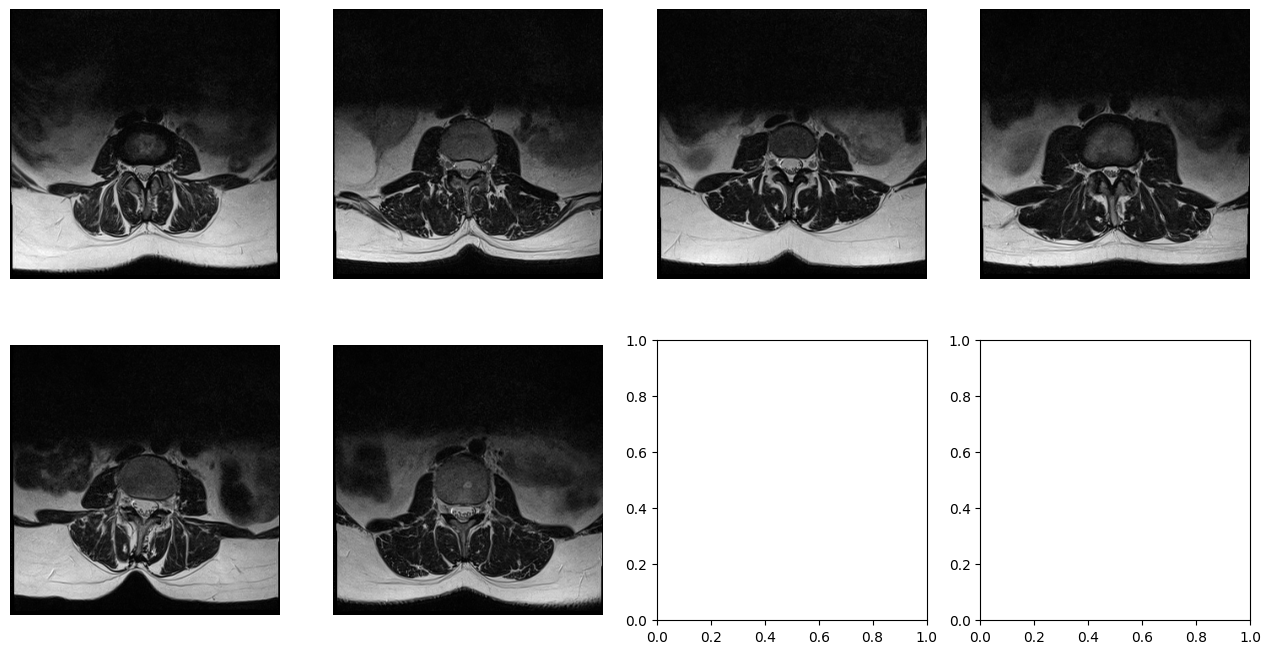

In [43]:
# suppose we want to retrieve information of this patient via image search
# first, we need to get the image embedding
embedding = resnet_model.embed([dicom.pixel_array])[0]
print(f"Image embedding shape: {embedding.shape}")

# then we can use the embedding to search in es
import numpy as np
response = es_helper.es_client.search(
    index="images",
    body={
        "query": {
            "knn": {
                "query_vector": list(embedding.squeeze().numpy().astype(np.float32)),
                "field": "image",
                "k": 6,
                "num_candidates": 100
            }
        }
    }
)

print(f"Top {len(response['hits']['hits'])} similar images found:")
for hit in response['hits']['hits']:
    print(f" - SOPInstanceUID: {hit['_source']['SOPInstanceUID']}, Score: {hit['_score']}")
azure_helper.show_images_from_response(response, size=(4,4))

### Case study 4: Predict Age via image

ROPInstanceUID: (0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.338294907212092058724332148592124191472
Patient's age: (0010,1010) Patient's Age                       AS: '053Y'
SeriesInstanceUID: (0020,000E) Series Instance UID                 UI: 1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0


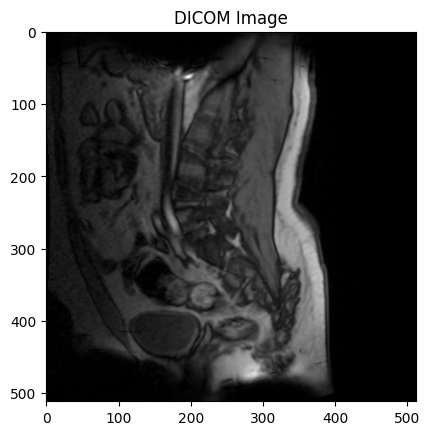

In [35]:
# load image of unindexed patient's mri scan
from helpers.ima_loader import load_dicom, show_dicom

dicom = load_dicom("images/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_001.ima")
print(f"ROPInstanceUID: {dicom['SOPInstanceUID']}")
print(f"Patient's age: {dicom['PatientAge']}")
print(f"SeriesInstanceUID: {dicom['SeriesInstanceUID']}")

show_dicom(dicom)

Image embedding shape: torch.Size([2048])
Top 6 similar images found:
{'_id': '0iFFkZkBuzq8TEdn5Hmm',
 '_index': 'images',
 '_score': 1.0000001,
 '_source': {'PatientAge': '053Y',
             'SOPInstanceUID': '1.3.6.1.4.1.9590.100.1.2.338294907212092058724332148592124191472',
             'SeriesInstanceUID': '1.3.12.2.1107.5.2.40.50233.2016030909181239634304374.0.0.0',
             'image_link': 'https://esimagedatastorage.blob.core.windows.net/mri-images/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_001.png'}}
{'_id': 'aiJYkpkBuzq8TEdnhCB9',
 '_index': 'images',
 '_score': 0.9328404,
 '_source': {'PatientAge': '045Y',
             'SOPInstanceUID': '1.3.6.1.4.1.9590.100.1.2.180043312310291297924389508412050978594',
             'SeriesInstanceUID': '1.3.12.2.1107.5.2.40.50233.2016010913525483869420626.0.0.0',
             'image_link': 'https://esimagedatastorage.blob.core.windows.net/mri-images/0512/L-SPINE_LSS_20160109_135229_694000/LOCALIZER_0001/LOCALI

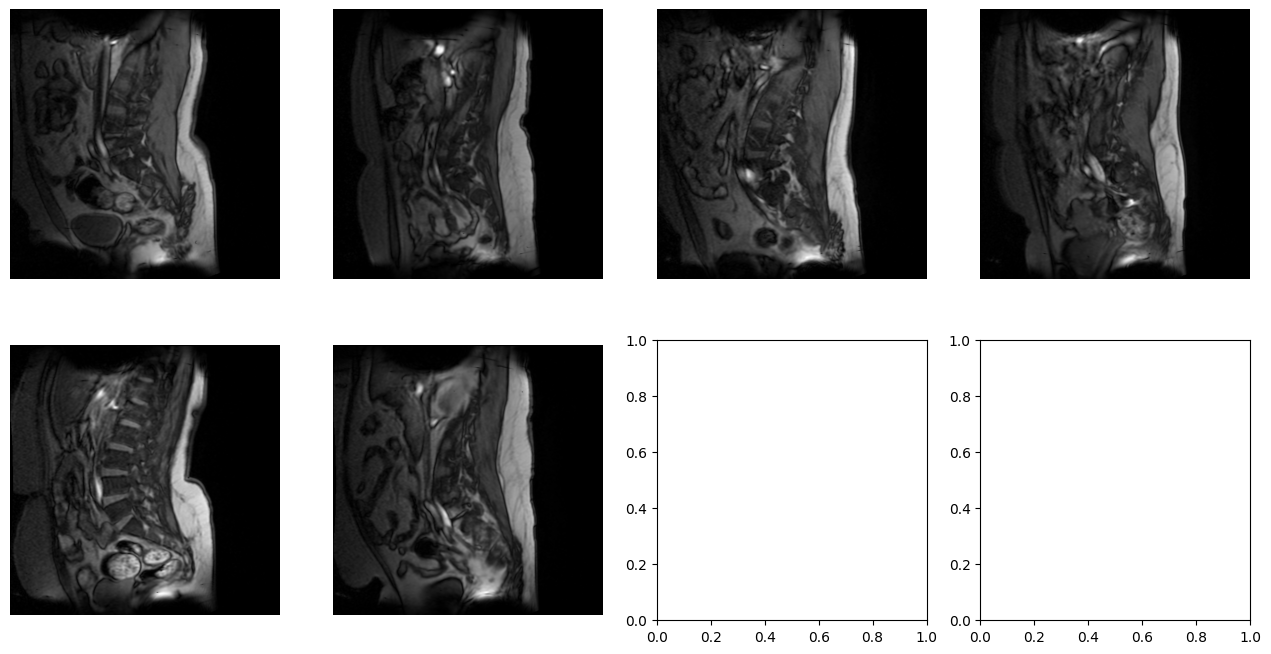

In [ ]:
# predict patient age of the mri image
# first, we get image embedding
embedding = resnet_model.embed([dicom.pixel_array])[0]

# then, we use kNN search to find similar images in the index
response = es_helper.es_client.search(
    index="images",
    body={
        "knn": {
            "query_vector": list(embedding.squeeze().numpy().astype(np.float32)), 
            "field": "image", 
            "k": 6, 
            "num_candidates": 100
        },
        "_source": ["SOPInstanceUID", "image_link", "SeriesInstanceUID", "PatientAge"]
    },
    
)
print(f"Top {len(response['hits']['hits'])} similar images found:")

for hit in response['hits']['hits']:
    pprint(hit)
    
# we can see that the first image is the same as the input image (distance = 0)
# as printed earlier, the actual patient age is 53
# now, suppose that that image hasn't been indexed, we can use the other similar images to predict the patient's age
ages = []
for hit in response['hits']['hits'][1:]:   # skip the first image
    age_str = hit['_source']['PatientAge']
    if age_str.endswith('Y'):
        ages.append(int(age_str[:-1]))
    elif age_str.endswith('M'):
        ages.append(int(age_str[:-1]) / 12)
    elif age_str.endswith('D'):
        ages.append(int(age_str[:-1]) / 365)
        
print(f"Predicted patient's age: {np.mean(ages):.2f} years (based on {len(ages)} similar images)")

azure_helper.show_images_from_response(response, size=(4,4))

## Embedding projection

### Finetuning

In [10]:
os.path.abspath("images/")

'd:\\Bachelor\\Curriculum\\HK251\\DBMS\\elastic-search\\images'

### PCA

### Quantization

## Anatomy of an IMA image

## Language-Vision Model (use Language to search for Image)